In [1]:
import pandas as pd
import torch
import torch.optim as optim
import numpy as np
import itertools

from transformers import BertTokenizer, get_linear_schedule_with_warmup, XLMRobertaTokenizer
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from BrandClassifier import BaselineClassifier, DeepClassifier
from DataPreprocess import BrandDataset

g:\Code\Python\GitHub\maboo\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_4 = pd.read_csv('brand_data\\brand_data_4.csv')
data_1 = pd.read_csv('brand_data\\brand_data_1.csv')
data = pd.concat([data_1.iloc[:, :2], data_4], axis=0)
le= LabelBinarizer()
# X = data['name']
# y = le.fit_transform(data['bra_整合'])
X_train, X_val, y_train, y_val = train_test_split(data['name'].values, data['brand'].values, test_size=0.2, random_state=89)

y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [3]:
# initialize training parameters
device = torch.device('cuda')
max_length = 64
batch_size = 64 # 128
lr = 0.0012 # 1e-5 # 5e-5 for the first run
epochs = 17
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# create dataset
train_dataset = BrandDataset(X_train, y_train, tokenizer=tokenizer, max_length=max_length)
val_dataset = BrandDataset(X_val, y_val, tokenizer=tokenizer, max_length=max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

data_num = len(train_dataset)
WARMUP_RATIO = 0.3
TOTAL_STEPS = (data_num // batch_size) * epochs if data_num % batch_size == 0 else \
    (data_num // batch_size + 1) * epochs

# create model
# model = DeepClassifier(class_num=len(le.classes_), freeze=False, bert_model='bert-base-multilingual-uncased') # freeze=True for the first run
model = DeepClassifier(class_num=len(le.classes_), freeze=False, bert_model='xlm-roberta-base')
# model.load_state_dict(torch.load('saved_model/Brand_classifier_temp.ckpt'))
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    [{'params': model.bert_model.parameters(), 'lr': 5e-5},
     {'params': model.classifier.parameters()}],
    lr=lr)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def train(train_loader=None, val_loader=None, model=None, epochs=None, criterion=None, optimizer=None, l1_lambda=None, l2_lambda=0.001):
    
    # scheduler_1 = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)
    # scheduler_2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=7, factor=0.5)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_RATIO*TOTAL_STEPS, num_training_steps=TOTAL_STEPS)
    
    all_train_accs = []
    all_train_loss = []
    all_val_accs = []
    all_val_loss = []
    
    for epoch in itertools.count():
        
        model.train()
        train_loss = []
        train_accs = []
        
        for batch in train_loader:
            
            ids = batch['ids'].to(device, dtype=torch.long)
            mask = batch['mask'].to(device, dtype=torch.long)
            y = batch['targets'].to(device, dtype=torch.float32)
            
            logits = model(ids, mask)
            loss = criterion(logits, y)
            
            # L1 regularization with normalized l1
            if l1_lambda is not None:
                L1_regularization = sum(p.abs().sum() for p in model.parameters())
                param_num = sum(p.numel() for p in model.parameters())
                loss += (l1_lambda / param_num) * L1_regularization
            
            # L2 regularization with normalized l2
            if l2_lambda is not None:
                L2_regularization = sum(p.pow(2.0).sum() for p in model.parameters())
                # param_num = sum(p.numel() for p in model.parameters())
                loss += l2_lambda * L2_regularization
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            scheduler.step()
            # scheduler_1.step()
            # scheduler_2.step(train_loss)
            
            acc = float(((logits.argmax(dim=-1) == y.argmax(dim=-1)).sum()).detach().cpu() / y.shape[0])
            train_loss.append(loss.item())
            train_accs.append(acc)
        
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)
        
        all_train_loss.append(train_loss)
        all_train_accs.append(train_acc)
        
        if val_loader is not None:
            model.eval()

            valid_loss = []
            valid_accs = []
            
            for batch in val_loader:
                
                ids = batch['ids'].to(device, dtype=torch.long)
                mask = batch['mask'].to(device, dtype=torch.long)
                y = batch['targets'].to(device, dtype=torch.float32)
                
                with torch.no_grad():
                    
                    logits = model(ids, mask)

                    acc = float(((logits.argmax(dim=-1) == y.argmax(dim=-1)).sum()).detach().cpu() / y.shape[0])
                    valid_loss.append(loss.item())
                    valid_accs.append(acc)
            
            valid_loss = sum(valid_loss) / len(valid_loss)
            valid_acc = sum(valid_accs) / len(valid_accs)
            
            all_val_loss.append(valid_loss)
            all_val_accs.append(valid_acc)
            
            if epochs is not None:
                print(f'[ {epoch+1}/{epochs} ] | train_loss = {train_loss:.5f}, train_acc = {train_acc:.5f}, val_loss = {valid_loss:.5f}, val_acc = {valid_acc:.5f}')
                if epoch+1 == epochs:
                    return model, [[all_train_accs, all_train_loss], [all_val_accs, all_val_loss]]
            else:
                print(f'[ {epoch+1} ] | train_loss = {train_loss:.5f}, train_acc = {train_acc:.5f}, val_loss = {valid_loss:.5f}, val_acc = {valid_acc:.5f}')
            
            # model saving
            if valid_acc >= max(all_val_accs):
                torch.save(model.state_dict(), 'saved_model/Brand_classifier_temp.ckpt')
            
            # stopping criterion    
            if (np.mean(all_train_loss[-5:]) < train_loss):
                print('Loss no longer decrease, stop training!')
                return model, [[all_train_accs, all_train_loss], [all_val_accs, all_val_loss]]
        
        else:
            if epochs is not None:
                print(f'[ {epoch+1}/{epochs} ] | train_loss = {train_loss:.5f}, train_acc = {train_acc:.5f}')
                if epoch+1 == epochs:
                    return model, [all_train_accs, all_train_loss]
            else:
                print(f'[ {epoch+1} ] | train_loss = {train_loss:.5f}, train_acc = {train_acc:.5f}')
        
        # model saving
        if train_acc >= max(all_train_accs):
            torch.save(model.state_dict(), 'saved_model/Brand_classifier_temp.ckpt')
        
        # stopping criterion    
        if (np.mean(all_train_loss[-15:]) < train_loss):
            print('Loss no longer decrease, stop training!')
            return model, [all_train_accs, all_train_loss]

In [5]:
model, history = train(train_loader=train_loader, val_loader=val_loader, model=model, epochs=epochs, criterion=criterion, optimizer=optimizer)

[ 1/17 ] | train_loss = 8954.55887, train_acc = 0.01294, val_loss = 8903.80371, val_acc = 0.01998
[ 2/17 ] | train_loss = 8804.81244, train_acc = 0.12387, val_loss = 8684.31348, val_acc = 0.23745
[ 3/17 ] | train_loss = 8519.43949, train_acc = 0.47166, val_loss = 8336.45215, val_acc = 0.80630
[ 4/17 ] | train_loss = 8115.15707, train_acc = 0.86049, val_loss = 7879.07080, val_acc = 0.93574
[ 5/17 ] | train_loss = 7610.22799, train_acc = 0.94866, val_loss = 7330.34131, val_acc = 0.95889
[ 6/17 ] | train_loss = 7043.18897, train_acc = 0.96852, val_loss = 6773.01367, val_acc = 0.96468
[ 7/17 ] | train_loss = 6528.33938, train_acc = 0.97678, val_loss = 6298.57031, val_acc = 0.97106
[ 8/17 ] | train_loss = 6090.29827, train_acc = 0.98059, val_loss = 5894.86084, val_acc = 0.97048
[ 9/17 ] | train_loss = 5717.80353, train_acc = 0.98452, val_loss = 5551.82227, val_acc = 0.97336
[ 10/17 ] | train_loss = 5402.16305, train_acc = 0.98762, val_loss = 5262.16650, val_acc = 0.98291
[ 11/17 ] | train_l

In [6]:
# torch.save(model, 'saved_model/baseline_classifier.ckpt')

In [7]:
import matplotlib.pyplot as plt

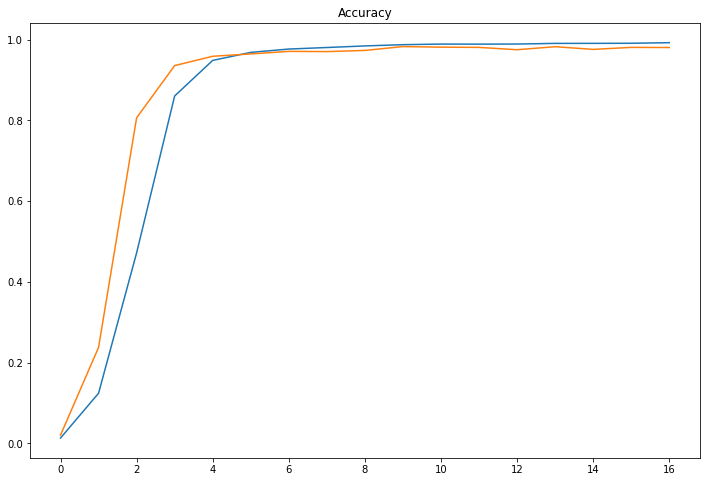

In [8]:
plt.figure(figsize=(12, 8))
plt.plot(history[0][0])
plt.plot(history[1][0])
plt.title('Accuracy')
plt.show()

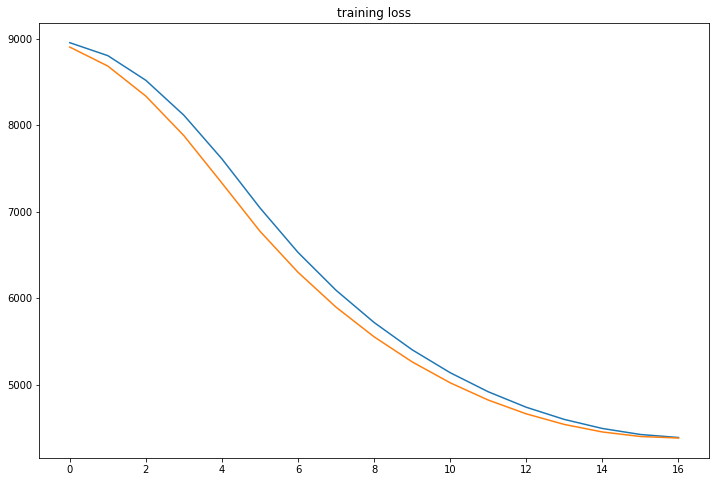

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(history[0][1])
plt.plot(history[1][1])
plt.title('training loss')
plt.show()